# Exploring Telco Data

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import wrangle as w
import explore as e
import scipy.stats as stats

In [2]:
# get telco data
df = w.get_telco()
df =  w.wrangle_telco_encoded(df)

In [3]:
# split the data
train, validate, test = w.train_validate_test(df, 'churn')
train

,customer_id,senior_citizen,partner,dependents,tenure,phone_service,paperless_billing,monthly_charges,total_charges,churn,...,tech_support_Yes,streaming_tv_No internet service,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
5911,8319-QBEHW,0,0,1,26,0,1,39.95,1023.75,0,...,0,0,1,0,0,1,0,0,0,0
2479,3547-LQRIK,0,1,0,47,1,0,26.90,1250.85,0,...,0,1,0,1,0,1,0,0,1,0
5889,8280-MQRQN,0,0,0,1,1,1,50.45,50.45,1,...,0,0,0,0,0,0,0,0,0,1
6087,8626-PTQGE,0,0,0,69,0,1,60.05,4176.70,0,...,1,0,1,0,1,0,1,0,0,0
785,1142-IHLOO,0,0,0,51,1,0,87.55,4475.90,0,...,0,0,1,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,8642-GVWRF,0,1,0,2,1,0,79.70,165.00,1,...,0,0,0,0,0,0,0,0,0,0
356,0523-VNGTF,1,0,0,52,0,1,50.50,2566.30,0,...,1,0,1,0,0,0,0,0,1,0
1756,2568-BRGYX,0,0,0,4,1,1,70.20,237.95,1,...,0,0,0,0,0,0,0,0,1,0
2127,3057-VJJQE,0,0,0,35,1,0,55.25,1924.10,0,...,0,0,0,0,0,0,1,0,0,1


# Is fiber optic a driver of churn?
$H_0$: Customers with fiber optic do not have a higher churn rate than those with DSL.
$H_a$: Customers with fiber optic have a higher churn rate than those with DSL.

In [4]:
# create a new column fiber_dsl that indicates whether or not the customer has fiber optic or dsl
fiber_vs_dsl = pd.concat([train.internet_service_type_fiber_optic, train.internet_service_type_dsl, train.churn], axis=1)
fiber_vs_dsl['fiber_dsl'] = np.where(fiber_vs_dsl['internet_service_type_fiber_optic'] == 1, 'fiber_optic',
                                     np.where(fiber_vs_dsl['internet_service_type_dsl'] == 1, 'dsl', 'neither'))

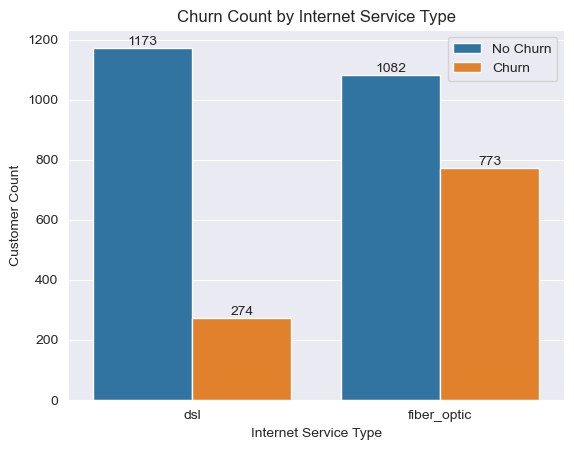

In [5]:
# plot the churn rate for each internet service type vs not churning
ax = sns.countplot(x='fiber_dsl', hue='churn', data=fiber_vs_dsl, order=['dsl', 'fiber_optic'])
for container in ax.containers:
    ax.bar_label(container)
# Label the plot
plt.title('Churn Count by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Customer Count')
plt.legend(['No Churn', 'Churn'])
plt.show()

In [6]:
# statistical test
# chi2 test to compare the proportions of two groups
observed = pd.crosstab(train.internet_service_type_fiber_optic, train.internet_service_type_dsl)

observed

internet_service_type_dsl,0,1
internet_service_type_fiber_optic,,
0,923,1447
1,1855,0


In [7]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(1719.7871802218215,
 0.0,
 1,
 array([[1558.31005917,  811.68994083],
        [1219.68994083,  635.31005917]]))

In [8]:
e.eval_results(p)

We reject the null hypothesis


### Takeaway: Fiber optic customers have a higher churn rate than DSL customers.

# Is fiber optic price a driver of churn?

$h_0$: Customers with fiber optic who pay more than the average monthly charge do not have a higher churn rate than those who pay less than the average monthly charge.
$h_a$: Customers with fiber optic who pay more than the average monthly charge have a higher churn rate than those who pay less than the average monthly charge.

In [9]:
# create a new column that indicates whether or not the customer pays more than the average monthly charge
train['above_avg_monthly_charge'] = train.monthly_charges > train.monthly_charges.mean()
df.monthly_charges.mean()

64.76169246059918

In [10]:
train.groupby('above_avg_monthly_charge').churn.mean()

above_avg_monthly_charge
False    0.165864
True     0.344228
Name: churn, dtype: float64

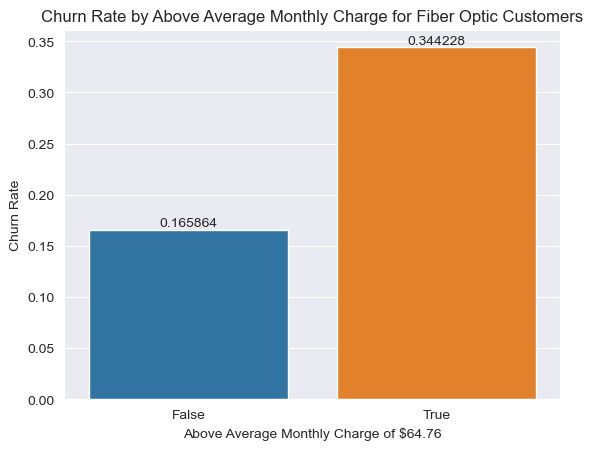

In [11]:
# plot the churn rate for each internet service type
ax = sns.barplot(x='above_avg_monthly_charge', y='churn', data=train, ci=False)
for container in ax.containers:
    ax.bar_label(container)

# Label the plot
plt.title('Churn Rate by Above Average Monthly Charge for Fiber Optic Customers')
plt.xlabel('Above Average Monthly Charge of $64.76')
plt.ylabel('Churn Rate')
plt.show()

In [12]:
# statistical test
# chi2 test to compare the proportions of two groups
observed = pd.crosstab(train.churn, train.above_avg_monthly_charge)
observed

above_avg_monthly_charge,False,True
churn,,
0,1559,1545
1,310,811


In [13]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(169.1827514262894,
 1.1159999823663982e-38,
 1,
 array([[1373.10674556, 1730.89325444],
        [ 495.89325444,  625.10674556]]))

### Takeaway: Customers with fiber optic who pay more than the average monthly charge have a higher churn rate than those who pay less than the average monthly charge.

# Is contract type a driver of churn?
$h_0$: Customers with month-to-month contracts do not have a higher churn rate than those with one or two year contracts.
$h_a$: Customers with month-to-month contracts have a higher churn rate than those with one or two year contracts.

In [14]:
# create a new column that indicates whether or not the customer has a month-to-month contract
train['contract_type_month_to_month'] = train['contract_type_One year'] + train['contract_type_Two year']
train['contract_type_month_to_month'] = np.where(train['contract_type_month_to_month'] == 0, 1, 0)
# combine the two year and one year contract types


In [15]:
# create dataframe with contract type and churn
contract_vs_churn = pd.concat([train['contract_type_month_to_month'], train['contract_type_One year'], train['contract_type_Two year'], train['churn']], axis=1)
# create column with contract type month to month or long term contract (one or two year)
contract_vs_churn['contract_type'] = np.where(contract_vs_churn['contract_type_month_to_month'] == 1, 'month_to_month',
                                              np.where(contract_vs_churn['contract_type_One year'] == 1, 'long_term', 'long_term'))
contract_vs_churn

,contract_type_month_to_month,contract_type_One year,contract_type_Two year,churn,contract_type
5911,0,1,0,0,long_term
2479,0,1,0,0,long_term
5889,1,0,0,1,month_to_month
6087,0,0,1,0,long_term
785,0,1,0,0,long_term
...,...,...,...,...,...
6102,1,0,0,1,month_to_month
356,1,0,0,0,month_to_month
1756,1,0,0,1,month_to_month
2127,0,0,1,0,long_term


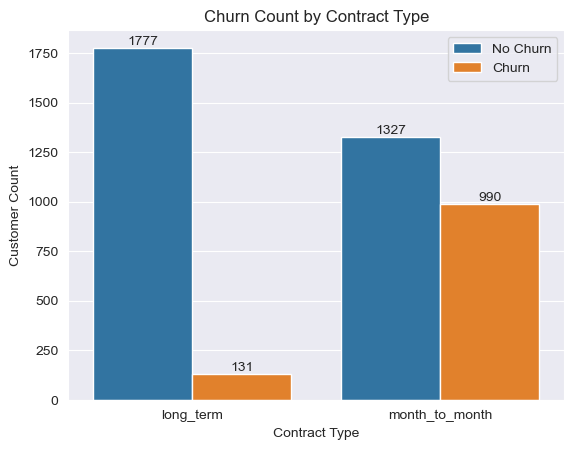

In [16]:
# plot value counts
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.countplot(x='contract_type', hue='churn', data=contract_vs_churn)
# Label the plot
for container in ax.containers:
    ax.bar_label(container)
plt.title('Churn Count by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Customer Count')
plt.legend(['No Churn', 'Churn'])
plt.show()


In [17]:
# statistical test
# chi2 test to compare the proportions of two groups
observed = pd.crosstab(contract_vs_churn.contract_type, contract_vs_churn.churn)
observed

churn,0,1
contract_type,,
long_term,1777,131
month_to_month,1327,990


In [18]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(688.5107252174398,
 9.422190060036814e-152,
 1,
 array([[1401.75905325,  506.24094675],
        [1702.24094675,  614.75905325]]))

In [19]:
e.eval_results(p)

We reject the null hypothesis


# Takeaway: Customers with month-to-month contracts have a higher churn rate than those with one or two year contracts.


# Are customers with dependents more likely to churn than those without?
$h_0$: Customers with dependents do not have a higher churn rate than those without dependents.
$h_a$: Customers with dependents have a higher churn rate than those without dependents.

In [20]:
train.groupby('dependents').churn.mean()

dependents
0    0.313204
1    0.156878
Name: churn, dtype: float64

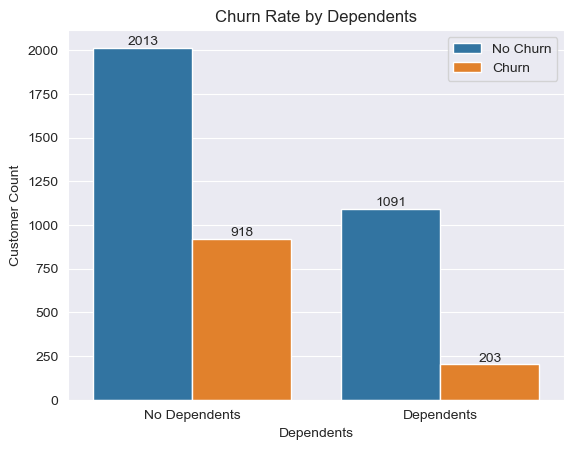

In [21]:
# plot the churn rate for each internet service type
ax = sns.countplot(x='dependents', hue='churn', data=train)
for container in ax.containers:
    ax.bar_label(container)
#label the plot
plt.title('Churn Rate by Dependents')
plt.xlabel('Dependents')
plt.ylabel('Customer Count')
plt.legend(['No Churn', 'Churn'])
plt.xticks([0, 1], ['No Dependents', 'Dependents'])
plt.show()


In [22]:
def plot_churn_rate_by_dependents(df):
    ax = sns.countplot(x='dependents', hue='churn', data=df)
    for container in ax.containers:
        ax.bar_label(container)
    #label the plot
    plt.title('Churn Rate by Dependents')
    plt.xlabel('Dependents')
    plt.ylabel('Customer Count')
    plt.legend(['No Churn', 'Churn'])
    plt.xticks([0, 1], ['No Dependents', 'Dependents'])
    plt.show()

In [23]:
# statistical test
# chi2 test to compare the proportions of two groups
observed = pd.crosstab(train.dependents, train.churn)
observed

churn,0,1
dependents,,
0,2013,918
1,1091,203


In [24]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
chi2, p, degf, expected

(111.74045071817625,
 4.0728740930257814e-26,
 1,
 array([[2153.33112426,  777.66887574],
        [ 950.66887574,  343.33112426]]))

In [25]:
e.eval_results(p)

We reject the null hypothesis
